In [1]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
minist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = minist.load_data()
x_train, x_test = x_train/255., x_test/255.

print('training size', x_train.shape)
print('test size', x_test.shape)

training size (60000, 28, 28)
test size (10000, 28, 28)


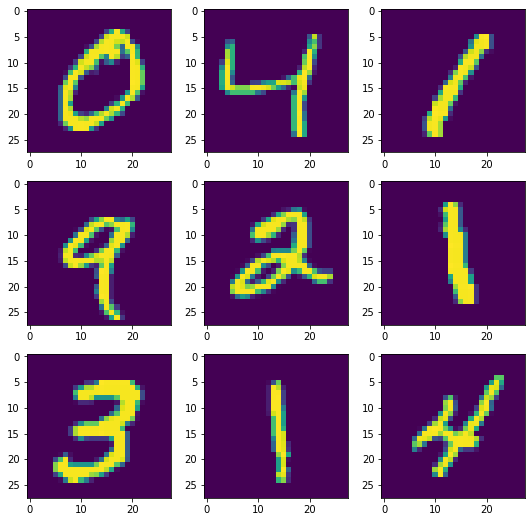

In [3]:
plt.figure(figsize=[9, 9])

for i in range(1, 10):
    plt.subplot(3, 3, i)
    plt.imshow(x_train[i])

## Model

In [4]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(10)
])

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


In the model, we have `784` input features, and in the first layer, we have `128` nodes, so the corresponding weights $W$ and $b$ would have size $(783, 128)$ and $(128, 1)$, which, in total adds up to

$$ 784 \times 128 + 128 = 100480$$

Same goes with the `dense_3` layer.

__Note__: It is possible to bake this tf.nn.softmax in as the activation function for the last layer of the network. While this can make the model output more directly interpretable, this approach is discouraged as it's impossible to provide an exact and numerically stable loss calculation for all models when using a softmax output.

In [6]:
predictions = model(x_train[:1])
print(predictions.numpy())

[[ 0.15655103 -0.48250246  0.29978698 -0.6595523  -0.27254325  0.18561608
  -0.42510659  0.32197294 -0.18982276 -1.2221566 ]]


Transfor into probability using `softmax`.

In [7]:
predictions = tf.nn.softmax(predictions)
print(predictions.numpy())

[[0.13328804 0.07034832 0.15381466 0.05893347 0.08678365 0.1372189
  0.07450415 0.15726532 0.0942677  0.03357577]]


## Loss Function

In `SparseCategoricalCrossentropy`, labels are to be provided as integers

In [8]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
loss_fn(y_train[:1], predictions).numpy()

2.2661917

## Train

In [9]:
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

In [10]:
model.fit(x_train, y_train, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 1s 620us/step - loss: 0.2957 - accuracy: 0.9146
Epoch 2/5
1875/1875 [==============================] - 1s 610us/step - loss: 0.1434 - accuracy: 0.9573
Epoch 3/5
1875/1875 [==============================] - 1s 610us/step - loss: 0.1056 - accuracy: 0.9686
Epoch 4/5
1875/1875 [==============================] - 1s 621us/step - loss: 0.0878 - accuracy: 0.9729
Epoch 5/5
1875/1875 [==============================] - 1s 620us/step - loss: 0.0737 - accuracy: 0.9772


## Evaluate

In [11]:
model.evaluate(x_test, y_test, verbose=2)

313/313 - 0s - loss: 0.0733 - accuracy: 0.9771


[0.0732896476984024, 0.9771000146865845]

## Predict

In [12]:
tf.argmax(model.predict(x_test[:5]), axis=-1).numpy()

array([7, 2, 1, 0, 4])

####################################################################################

In [1]:
import tensorflow as tf

from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model

In [2]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Add a channels dimension
x_train = x_train[..., tf.newaxis].astype("float32")
x_test = x_test[..., tf.newaxis].astype("float32")

print('train shape', x_train.shape)
print('test shape', x_test.shape)

train shape (60000, 28, 28, 1)
test shape (10000, 28, 28, 1)


## Get Batch

In [3]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

## Model

In [4]:
class MyModel(Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = Conv2D(32, 3, activation='relu')
        self.flatten = Flatten()
        self.dense1 = Dense(128, activation='relu')
        self.dense2 = Dense(10)
        
    def call(self, x):
        x = self.conv1(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        # softmax need not to apply
        return x

model = MyModel()

## Optimizer and Loss

These metrics accumulate the values over epochs and then print the overall result.

In [5]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [6]:
loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

In [7]:
# step of one batch
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images)
        loss = loss_obj(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    train_loss(loss)
    train_accuracy(labels, predictions)

In [8]:
@tf.function
def test_step(images, labels):
    # training=False is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=False)
    t_loss = loss_obj(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)

## Training

In [9]:
EPOCHS = 5
for epoch in range(EPOCHS):
    # re-calculate loss and accuracy of each epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()
    
    for images, labels in train_ds:
        train_step(images, labels)
        
    for images, labels in test_ds:
        test_step(images, labels)
    
    print(
        f'Epoch {epoch + 1}, '
        f'Loss: {train_loss.result()}, '
        f'Accuracy: {train_accuracy.result() * 100}, '
        f'Test Loss: {test_loss.result()}, '
        f'Test Accuracy: {test_accuracy.result() * 100}'
    )

Epoch 1, Loss: 0.1341124325990677, Accuracy: 96.08833312988281, Test Loss: 0.07015062868595123, Test Accuracy: 97.7699966430664
Epoch 2, Loss: 0.04252898693084717, Accuracy: 98.69166564941406, Test Loss: 0.05851253867149353, Test Accuracy: 98.13999938964844
Epoch 3, Loss: 0.02277100831270218, Accuracy: 99.24666595458984, Test Loss: 0.05304492637515068, Test Accuracy: 98.38999938964844
Epoch 4, Loss: 0.012743637897074223, Accuracy: 99.58499908447266, Test Loss: 0.057635437697172165, Test Accuracy: 98.3499984741211
Epoch 5, Loss: 0.00996498391032219, Accuracy: 99.66999816894531, Test Loss: 0.07684854418039322, Test Accuracy: 98.23999786376953
